<a href="https://colab.research.google.com/github/AfrozSaqlain/Physics-Informed-Neural-Network/blob/main/TISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy.special import hermite
from scipy.linalg import eigh_tridiagonal

In [93]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We know that the Schrodinger equation looks like:

$$
  - \frac{\hbar^2}{2m} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi(x) = E \psi(x)
$$

Taking the potential to be a simple harmonic oscillator, we have

$$V(x) = \frac{1}{2} m \omega^2 x^2$$

Thus, our Schrodinger equation will then look like:

$$
  \left[- \frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} m \omega^2 x^2 \right] \psi(x) = E \psi(x)
$$

The energy eigenvalue is then given by:

$$
  E_n = \hbar \omega \left( n + \frac{1}{2} \right)
$$

In [94]:
class TISE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TISE, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layer(x)

In [95]:
def potential(x):
  return (1/2) * (x**2)

def energy(n):
  return n + 1/2

# def residual(model, potential, x, n):
#   x = x.requires_grad_(True)
#   psi = model(x)
#   dy_dx = torch.autograd.grad(
#         psi, x, grad_outputs=torch.ones_like(psi), create_graph=True
#     )[0]
#   d2y_dx2 = torch.autograd.grad(
#         dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True
#     )[0]
#   res = - (1/2) * d2y_dx2 + potential(x) * psi - energy(n) * psi
#   return torch.mean(res**2)

def residual(model, potential, x, n):
    x = x.requires_grad_(True)
    psi = model(x)

    dy_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True, retain_graph=True)[0]

    res = - (1/2) * d2y_dx2 + potential(x) * psi - energy(n) * psi
    return torch.mean(res**2)


# def bc_loss(model, x, boundary):
#   left_bc = torch.tensor([[boundary[0]]])
#   right_bc = torch.tensor([boundary[1]])
#   psi_0 = model(left_bc)
#   psi_1 = model(right_bc)
#   return torch.abs(psi_0**2 + psi_1**2)

def bc_loss(model, boundary):
    x_bc = torch.tensor([[boundary[0]], [boundary[1]]], dtype=torch.float32).to(DEVICE)
    psi_bc = model(x_bc)
    return torch.mean(psi_bc ** 2)


def total_loss(model, x, n, boundary):
  return 1e0 * residual(model, potential, x, n) + bc_loss(model, boundary)

# def train_pinn(model, n, boundary, optimizer, scheduler, x_train, epochs, patience):
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         loss = total_loss(model, x_train, n, boundary)
#         loss.backward()
#         optimizer.step()

#         scheduler.step(loss)

#         if epoch % 500 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")

#         if scheduler.num_bad_epochs >= patience:
#             print("Training stopped early due to plateau in learning.")
#             break

def train_pinn(model, n, boundary, optimizer, scheduler, x_train, epochs, patience=500):
    best_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_train, n, boundary)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Early stopping mechanism
        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Training stopped early due to plateau in learning.")
            break

In [96]:
model_0 = TISE(input_size = 1, hidden_size = 20, output_size = 1)
# optimizer = optim.Adam(model_0.parameters(), lr=0.01)
optimizer = optim.AdamW(model_0.parameters(), lr=0.001, weight_decay=1e-5)


# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6
# )
epochs = 10000
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

In [97]:
boundary = (-5.0, 5.0)
n = 4

N_collocation = 1000
x_train = torch.tensor(np.linspace(boundary[0], boundary[1], N_collocation), dtype=torch.float32).unsqueeze(1)
x_train = x_train.to(DEVICE)

In [98]:
train_pinn(model_0, n, boundary, optimizer, scheduler, x_train, epochs, patience=200)

Epoch 0, Loss: 0.21413616836071014, Learning Rate: 0.0009999999753506632
Epoch 500, Loss: 9.371357009513304e-05, Learning Rate: 0.0009938257536861758
Epoch 1000, Loss: 7.754488251521252e-06, Learning Rate: 0.000975504214711626
Epoch 1500, Loss: 4.834568017031415e-07, Learning Rate: 0.0009454864955222663
Epoch 2000, Loss: 2.489533130756172e-07, Learning Rate: 0.0009045117319876397
Epoch 2500, Loss: 2.3736772902793746e-07, Learning Rate: 0.0008535888587734127
Epoch 3000, Loss: 2.2920229980627482e-07, Learning Rate: 0.000793971766021448
Epoch 3500, Loss: 2.206343481248041e-07, Learning Rate: 0.0007271284244130841
Epoch 4000, Loss: 2.111647177116538e-07, Learning Rate: 0.0006547047388590505
Epoch 4500, Loss: 2.008695787480974e-07, Learning Rate: 0.0005784840208581198
Epoch 5000, Loss: 1.899350934309041e-07, Learning Rate: 0.0005003430774495355
Epoch 5500, Loss: 1.7869936641545792e-07, Learning Rate: 0.0004222059979949395
Epoch 6000, Loss: 1.675015539603919e-07, Learning Rate: 0.00034599677

In [99]:
y_val = model_0(x_train)

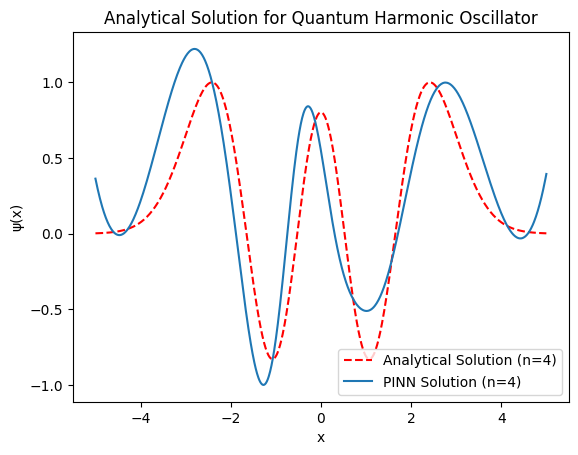

In [100]:
def analytical_wavefunction(n, x):
    H_n = hermite(n)
    norm_factor = 1 / np.sqrt(2**n * math.factorial(n) * np.sqrt(np.pi))
    return norm_factor * np.exp(-x**2 / 2) * H_n(x)

def harmonic_potential(x):
    return 0.5 * x**2

x_vals = np.linspace(boundary[0], boundary[1], N_collocation)

psi_analytical = analytical_wavefunction(n, x_vals)

psi_analytical /= np.sqrt(np.trapz(psi_analytical**2, x_vals))


plt.plot(x_vals, psi_analytical / np.max(psi_analytical), label=f"Analytical Solution (n={n})", linestyle="--", color="red")
plt.plot(x_train.detach().numpy(), - y_val.detach().numpy() / np.max(y_val.detach().numpy()), label=f"PINN Solution (n={n})")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.title("Analytical Solution for Quantum Harmonic Oscillator")
plt.show()

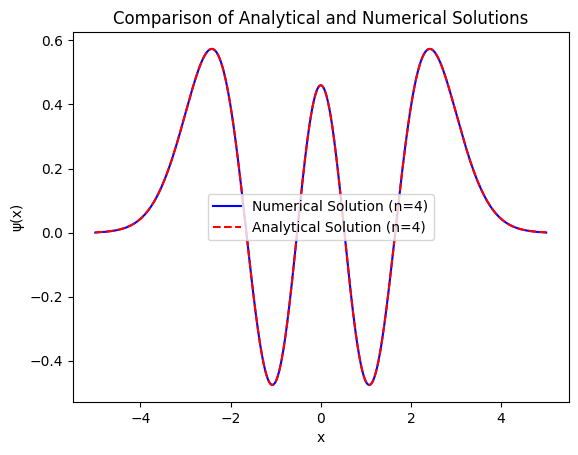

In [101]:
# Numerical solution using finite difference method
def numerical_schrodinger(N, x_min, x_max):
    """ Solve the Schrödinger equation numerically using finite differences. """
    x_vals = np.linspace(x_min, x_max, N)
    h = x_vals[1] - x_vals[0]  # Step size

    # Discretized second derivative (Laplacian)
    diag = 1 / h**2 + harmonic_potential(x_vals)
    off_diag = np.full(N - 1, -1 / (2 * h**2))

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh_tridiagonal(diag, off_diag)

    return x_vals, eigenvalues, eigenvectors

# Solve numerically
N = 1000
x_vals, eigvals, eigvecs = numerical_schrodinger(N, -5, 5)

# Extract numerical eigenfunction for n=4
psi_numerical = eigvecs[:, n]

# Normalize
psi_numerical /= np.sqrt(np.trapz(psi_numerical**2, x_vals))

# Plot numerical vs analytical solution
plt.plot(x_vals, psi_numerical, label=f"Numerical Solution (n={n})", linestyle="solid", color="blue")
plt.plot(x_vals, psi_analytical, label=f"Analytical Solution (n={n})", linestyle="--", color="red")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.title("Comparison of Analytical and Numerical Solutions")
plt.show()